In [205]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model

In [182]:
df = pd.read_csv('master_data.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df = df.loc['1989-07-7':]
df['label_day'] = ~df['decision'].isna()
df = df.fillna(method='ffill')
df = df.iloc[1:]


In [219]:
monthly = ['pce','ue','cars','recess','house','cli','loan','exports','rgdp','gdpg','veloc', 'ffr']
labels = ['decision', 'ffr']
daily = ['spx','usd', ]
categorical = ['fed_party','potus_party']

# don't include label_day, change, 
# y label is decision, and regress label is frr

# forward fill all nan values
def betafy(df, key = 'label_day', start = 7, end = 60, cat_col = [], daily_col = [], other = [], labels = []):
    # Get our different dataframes
    categorical = df[cat_col]
    daily = df[daily_col]
    monthly = df[other]
    keep = df[key]
    labels = df[labels]

    # create the windows
    event_days = df[df[key]].index
    

    ################## Handle Categorical and Label Data ##################
    cat_collapsed = categorical[keep]
    y_labels = labels[keep]


    ################## Handle Monthly Data ##################
    # Create event windows
    windows = []
    for day in event_days:
        # Calculate start and end days of the window
        start_day = day - pd.Timedelta(days=start)
        end_day = day - pd.Timedelta(days=end)

        # Ensure start_day is not before the start of the dataset
        if end_day < df.index[0]:
            end_day = df.index[0]

        windows.append((start_day, end_day))

    # Initialize a list to store aggregated data
    aggregated_data = []

    for (start_day, end_day) in windows:
        # Select data within the window
        window_data = monthly.loc[end_day:start_day]

        # Apply your custom aggregation function
        final_vals = window_data.loc[start_day]
        change = final_vals - window_data.iloc[0]
        # relabel the change columns to include a d_ prefix
        change = change.rename(lambda x: 'd_' + x)

        # concatenate the data horizontally
        aggregated_window = pd.concat([final_vals, change], axis=0)
        aggregated_data.append(aggregated_window)

    # Combine aggregated data
    aggregated_monthly = pd.concat(aggregated_data, axis=1).T
    aggregated_monthly.index = event_days

    ################## Handle Daily Data ##################
    # define the model
    model = linear_model.LinearRegression()
    daily_agg = []

    # Get the names of the features
    daily_feat = daily.columns
    b0_name = ['b0_' + feat for feat in daily_feat]
    b1_name = ['b1_' + feat for feat in daily_feat]

    for (start_day, end_day) in windows:
        # Select data within the window
        window_data = daily.loc[end_day:start_day]
        time = np.arange(len(window_data)).reshape(-1, 1)

        # Initialize lists to store betas for each feature
        beta0 = []
        beta1 = []

        # Loop through each feature and fit the model
        for feat in daily_feat:
            model.fit(time, window_data[feat])
            beta0.append(model.intercept_)
            beta1.append(model.coef_[0])

        # Create DataFrames for betas
        beta0_df = pd.DataFrame([beta0], columns=b0_name)
        beta1_df = pd.DataFrame([beta1], columns=b1_name)

        # concatenate the data horizontally
        aggregated_window = pd.concat([beta0_df, beta1_df], axis=1)
        daily_agg.append(aggregated_window)

    # Combine aggregated data
    aggregated_daily = pd.concat(daily_agg, axis=0)
    aggregated_daily.index = event_days

    ################## Combine Data ##################
    # Combine all data
    combined = pd.concat([cat_collapsed, aggregated_monthly, aggregated_daily], axis=1)
    return combined, y_labels


data, labels = betafy(df, cat_col = categorical, daily_col = daily, other = monthly, labels = labels)
data.to_csv('beta_data.csv')
labels.to_csv('labels.csv')




In [184]:
df

,ffr,change,decision,loan,exports,pce,ue,rgdp,cars,recess,gdpg,veloc,house,cli,spx,usd,fed_party,potus_party,label_day
1989-07-08,9.25,-25.0,-1.0,11.0,4.1,4.04,5.2,3.0,14.695,0.0,3.0,7.307,1427.0,99.71910,324.910004,98.309998,1.0,1.0,False
1989-07-09,9.25,-25.0,-1.0,11.0,4.1,4.04,5.2,3.0,14.695,0.0,3.0,7.307,1427.0,99.71910,324.910004,98.309998,1.0,1.0,False
1989-07-10,9.25,-25.0,-1.0,11.0,4.1,4.04,5.2,3.0,14.695,0.0,3.0,7.307,1427.0,99.71910,324.910004,98.309998,1.0,1.0,False
1989-07-11,9.25,-25.0,-1.0,11.0,4.1,4.04,5.2,3.0,14.695,0.0,3.0,7.307,1427.0,99.71910,327.070007,98.000000,1.0,1.0,False
1989-07-12,9.25,-25.0,-1.0,11.0,4.1,4.04,5.2,3.0,14.695,0.0,3.0,7.307,1427.0,99.71910,328.779999,98.900002,1.0,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-30,5.40,0.0,0.0,8.5,6.0,3.64,3.9,5.2,15.972,0.0,3.5,1.511,1372.0,99.47179,4550.580078,102.769997,1.0,0.0,False
2023-12-01,5.40,0.0,0.0,8.5,6.0,3.64,3.9,5.2,15.972,0.0,3.5,1.511,1372.0,99.47179,4567.799805,103.500000,1.0,0.0,False
2023-12-02,5.40,0.0,0.0,8.5,6.0,3.64,3.9,5.2,15.972,0.0,3.5,1.511,1372.0,99.47179,4594.629883,103.269997,1.0,0.0,False
2023-12-03,5.40,0.0,0.0,8.5,6.0,3.64,3.9,5.2,15.972,0.0,3.5,1.511,1372.0,99.47179,4594.629883,103.269997,1.0,0.0,False


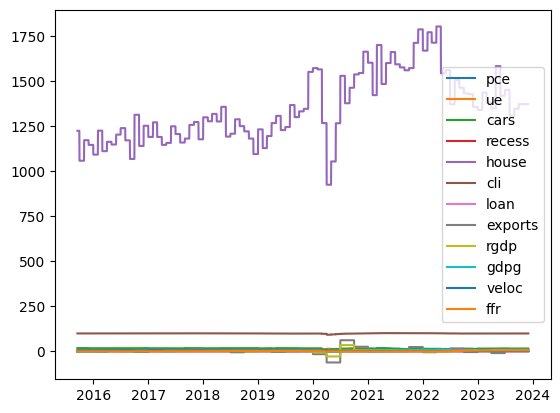

In [185]:
plt.plot(df[monthly][-3000:])
plt.legend(monthly)